In [1]:
%matplotlib inline

'''
Use %matplotlib inline instead of %matplotlib widget when preparing the final report. 
Otherwise the images are, unfortunately, not embedded in the pdf. 
'''
from importstatements import *
from pylab import *
from scipy.signal import firwin, lfilter, filtfilt
from scipy.io import loadmat
css_styling()

$
\newcommand{\fsamp}{{F_s}}
\newcommand{\tsamp}{{T_s}}
\newcommand{\unit}[1]{\ensuremath{\text{#1}}}
\newcommand{\tmidx}{n}
\newcommand{\tds}[2][\tmidx]{{#2(#1)}}
\newcommand{\matcmd}[2][(\cdot)]{\texttt{#2}#1}
\renewcommand{\matcmd}[2][(\cdot)]{\mathrm{#2}#1}
\newcommand{\fcn}[1]{{\text{#1}}}
\newcommand{\bigcb}[1]{{\big\{#1\big\}}} 
\newcommand{\Bigcb}[1]{{\Big\{#1\Big\}}}
\newcommand{\bigsb}[1]{{\big[#1\big]}} 
\newcommand{\Bigsb}[1]{{\Big[#1\Big]}}
\newcommand{\biggsb}[1]{{\bigg[#1\bigg]}}
\newcommand{\pyt}{\matcmd[]{Python}}
\newcommand{\fds}[2][z]{#2(#1)}
\newcommand{\zpow}[1][-1]{z^{#1}}
\newcommand{\cbr}[1]{\big\{#1\big\}}
\newcommand{\mat}[1]{\boldsymbol{#1}}
$

# Practical aspects of filtering

We have seen that filtering is simply the selection of desired parts of the signal and the suppression of unwanted components. Thus far we have not only learnt how to characterise and design filters with desired spectral characteristics (low-pass, band-pass, notch, ...), but also how to design filters that are _adaptive_ (they change their characteritics automatically, depending on the input). In this lab session we will round off our journey into filter design by investigating certain practical aspects. 

In the _first_ part you will learn how numerical errors in representing filter coefficients can have unexpected consequences and you will see how to avoid such issues. In the _second_ part of the exercise we shall take a closer look at the phase response of filters. Thus far we have seen the phase response only in passing - the amplitude response was given more importance. However, not considering the phase response can have consequences for biomedical signal processing - as we shall see.

This exercise is in part adapted from the examples provided in the textbook "Case Studies in Neural Data Analysis", by Mark Kramer and Uri Eden (2016, MIT Press) and the 2020 eLife-LABs publication by Emily Schlafly, Anthea Cheung, Samantha Michalka, Paul Lipton, Caroline Moore-Kochlacs, Jason Bohland, Uri Eden, Mark Kramer.

------
# Part 1: Effects of numerical precision on stability. 

The frequency response of a filter is determined by its poles and zeroes. By adjusting them - i.e. moving them in the Z-plane - different frequencies can be emphasised or attenuated. In our previous exercises, we always assumed that sufficient numerical accuracy was available to represent any pole or zero. What happens if the numerical accuracy is limited - which can happen in limited resource computing platforms (like the popular ARM controller)? The limited precision (limited number of bits) can end up _quantising_ the locations of the poles or zeros, rounding off their values. This leads to a shift of the implemented poles and zeroes away from the designed values. Let us see what the effect of this can be - and, rather surprisingly, we do not need to go to limited precision platforms to see this. Our own computers, with double precision arithmetic, can sometimes fail as well!

<div class="alert alert-info">

**Task**
    
In the lecture we have seen that numerical accuracies in representing the polynomial coefficients can lead to the roots of the polynomial falling on or outside the unit circle.
    
* How does this affect the stability of an IIR filter?
* How does this affect the stability of an FIR filter?
    
Justify your answers in both cases.
    

<div class="alert alert-success">
<span style="color:black">
  
* Text answers go in these type of boxes

For an IIR filter this effect can lead to the situation where its poles can fall on or outside the unit circle resulting in an unstable filter. An FIR filter in contrast does not have any poles, hence its stability is not affected by this phenomena.
    

Now we shall assess the effects of numerical inaccuracies on the stability of IIR filters. Specifically, we shall compare the position of zeroes and poles of a _combined_ notch filter that filters several different frequencies against a _cascaded_ version. 

A notch-filter that notches frequency $F_i\tsamp$, as you would have realised from Exercise 3, can be realised as a 2nd order IIR filter. We shall denote such a filter as: $\fds{H_i} = \dfrac{\fds{B_i}}{\fds{A_i}}$.

A _combined_ notch filter, for the set of frequencies $F_i \in \{F_1, F_2,\ldots\,,F_N \}$, can be represented by the single IIR filter as:
$$\fds{H} = \dfrac{\prod_{i=1}^{N} \fds{B_i}}{\prod_{i=1}^{N} \fds{A_i}}  = \dfrac{\fds{B}}{\fds{A}}$$
The output of this filter is then obtained by $\fds{Y} = \fds{H}\fds{X}$. Think of this as designing a _single_ long filter that notches all frequencies in the given set.

A _cascaded_ notch filter, on the other hand, processess the input in a _sequential_ manner, with the output of a previous stage being the input to the next stage. Thus:
$$\fds{Y_{i}} = \fds{H_{i}}\fds{Y_{i-1}}$$ and we have $\fds{Y_0} = \fds{X}$. Think of this as _several_ 2nd order notch filters joined in series, where each notch filter is responsible for notching only a single frequency.

In theory, both implementations should be identical - the multiplication of polynomials in the first version (combined filter) is implicit in the cascaded version. Are they similar in practice as well?

*To create a notch-filter, you can use the function you have created in Exercise 3.* 

<div class="alert alert-info">

**Task**

* Express $\fds{H}$ of the cascaded filter as a function of the $\fds{H_i}$.

<div class="alert alert-success">
<span style="color:black">
    
* Text answers go here

$$H(z)=\prod^N_{i=1}H_i(z)$$

<div class="alert alert-info">
    
* Assume $\fsamp=16\text{kHz}$ and generate notch filters $\fds{H_i}$ to notch frequencies $F_i = kF$, where $F=50$ and $i\in\{1,2,\ldots\,N\}$. Choose a $3 \text{dB}$ bandwidth of $\text{BW} = 10 \text{Hz}$.
* Start with $N=2$ and plot the poles \& zeros as well as the _amplitude_ response of:
    * the _combined_ system and
    * the _cascaded_ system
    * Increase $N$ by 1 and repeat the above step till $N=8$. When do the systems begin to diverge? 

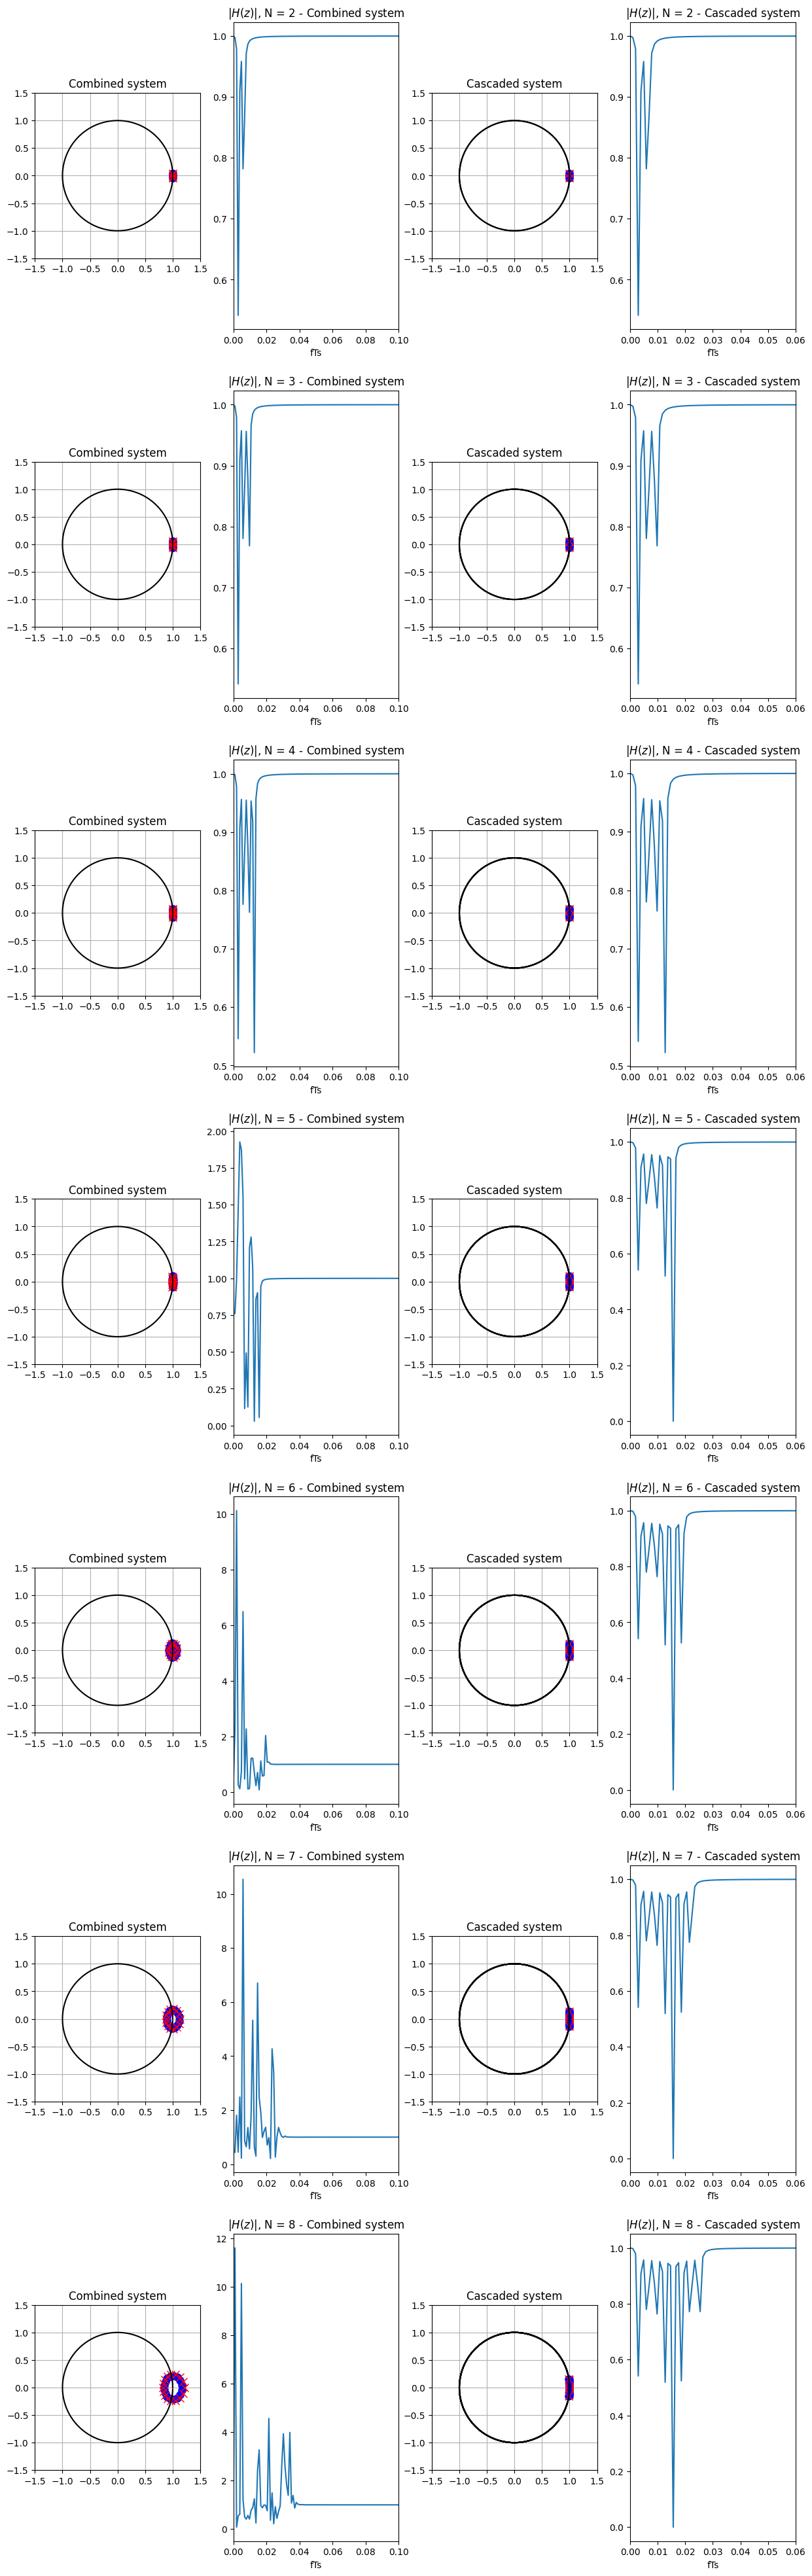

In [3]:
# Your Code Goes Here

def PoleZeroPlot(ax, B,A=(1,)):

    zeroes = np.roots(np.array(B))
    poles = np.roots(np.array(A))
    ax.plot(np.real(zeroes),np.imag(zeroes),'o',color='b',markersize=8)
    ax.plot(np.real(poles),np.imag(poles),'x',color='r',markersize=8)
    ax.set_xlim((-1.5,1.5))
    ax.set_ylim((-1.5,1.5))
    # Plot the unit circle
    ax.plot(np.cos(np.arange(0,2*np.pi,np.pi/100)),np.sin(np.arange(0,2*np.pi,np.pi/100)),\
            color='k')
    ax.set_aspect('equal')
    ax.grid('on')

def PolynomialMultiply(polyA,polyB):
    return np.convolve(polyA,polyB)

def NotchFilter(FcTs,BTs):
    Q = FcTs/BTs
    Bz,Az = signal.iirnotch(FcTs,Q=Q,fs=1)
    return Bz,Az

fig, ax = plt.subplots(ncols=4, nrows=7, figsize=(15,50))

Fs, F, BW = 16000, 50, 10 
Bz1, Az1 = NotchFilter(F/Fs, BW/Fs)
f,Hf_cascaded = signal.freqz(Bz1,Az1,fs=Fs)
Bz, Az = Bz1, Az1
L = [(Bz1, Az1)]
for i in range(7):

    Bzi, Azi = NotchFilter((i+2)*F/Fs, BW/Fs)
    L.append((Bzi,Azi))
    
    # Combinend system

    Bz, Az = PolynomialMultiply(Bz, Bzi), PolynomialMultiply(Az, Azi)
    f,Hf_combined = signal.freqz(Bz,Az,fs=Fs)

    PoleZeroPlot(ax[i,0], Bz, Az)
    ax[i,0].set_title('Combined system')
    ax[i,1].plot(f/Fs, abs(Hf_combined))
    ax[i,1].set_xlim((0,0.1))
    ax[i,1].set_xlabel('fTs')
    ax[i,1].set_title(f'$|H(z)|$, N = {i+2} - Combined system')

    # Cascaded system


    f,Hfi = signal.freqz(Bzi,Azi,fs=Fs)
    Hf_cascaded *= Hfi

    for bi, ai in L:
        PoleZeroPlot(ax[i,2], bi, ai)
    ax[i,2].set_title('Cascaded system')
    ax[i,3].plot(f/Fs, abs(Hf_cascaded))
    ax[i,3].set_xlim((0,0.06))
    ax[i,3].set_xlabel('fTs')
    ax[i,3].set_title(f'$|H(z)|$, N = {i+2} - Cascaded system')

# divergence starting from N=5!!!!


<div class="alert alert-info">    

* Which system would you implement in practice and why?
* Based on your observations, explain (briefly) how you would implement a long IIR filter $\fds{H} = \dfrac{\fds{B}}{\fds{A}}$ in practice to avoid unexpected results.

<div class="alert alert-success">
<span style="color:black">
    
* Text answers go here

In practice the cascaded notch filter would be implemented because its presicion is unaltered with the amount of notch filters added. A long IIR filter $H(z) = \frac{B(z)}{A(z)}$ would be split into factors (polynomial fractions), and depending on the type of filters included in $H(z)$ the respective numerators and denominators would be grouped together and then one at a time applied to a signal just as explained above.

------
# Part 2: Effect of phase response

In the second part of this lab session we will evaluate how different types of phase responses can impact the analysis (and interpretation) of your EEG analysis. We shall design standard filters to isolate, emphasize, or remove rhythmic activity in neural field data. Such filtering is typically applied as a preprocessing step in analysis of EEG data but _how_ the filtering is performed can may make or break subsequent analysis. The aim is to create some intuition and awareness regarding aspects that you need to think of when using an "off-the-shelf" filter in your EEG analysis pipeline.

The data are electroencephalogram (EEG) recorded from the virtual cortex area (left occipital lobe) of a human subject during a task. The dataset consists of ten trials of EEG data, each of 1s duration, recorded during the subject’s response to a visual stimulus (a small flash of light).

The data matrix `eeg` has rows corresponding to single trials, each consisting of 1,000 indices. The visual stimulus is delivered just after the start of the trial (at time 0.001 s, corresponding to index 0 of variable `t`), and the response is recorded for the subsequent 1 s (the time 1 s corresponds to index 999 of variable `t`).

In [2]:
data = loadmat('./EEG-1.mat')  # Load the EEG data
eeg = data['EEG']            # Extract the EEG variable
t = data['t'][0]             # ... and the t variable containing the sampling time instants 

fs = 1/t[0] # Compute the sampling frequency - you will need this for later!

<div class="alert alert-info">

**Task: Data visualisation**
    
- Inspect a single trial of the EEG recording in the time and frequency domain. What types of rythmic structure do you observe, and at which frequencies?
- What is the frequency resolution of the recording? What might the dominant spectral peak correspond to (note that the recording was made in the USA).
- Examine the other individual trials. Do you find similar features than in the first trial?    

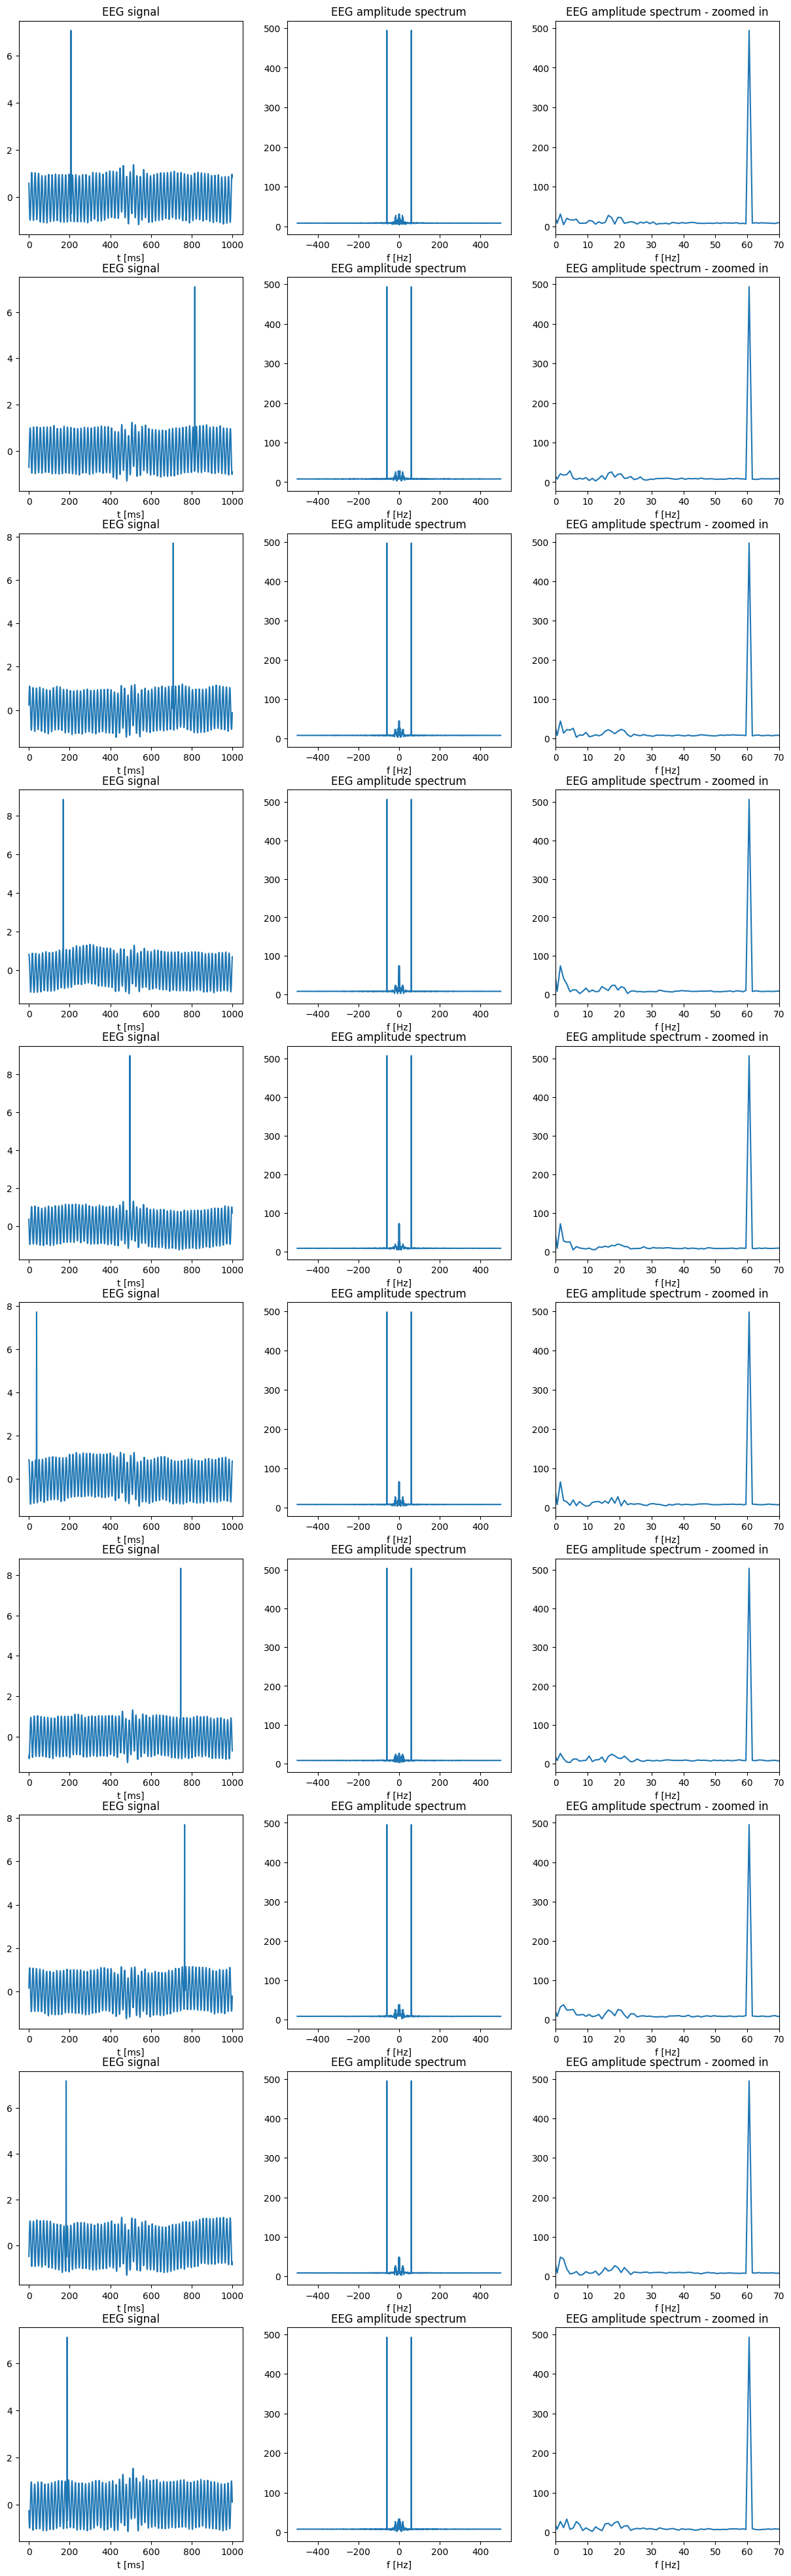

In [3]:
#Your Code Goes Here
import scipy

fig, ax = plt.subplots(nrows=eeg.shape[0], ncols=3, figsize=(15,50))
f = np.linspace(-fs/2,fs/2,1000)

for i in range(eeg.shape[0]):

    eegi = eeg[i]
    EEGi = scipy.fft.fftshift(fft(eegi))

    ax[i,0].plot(eegi)
    ax[i,0].set_xlabel('t [ms]')
    ax[i,0].set_title('EEG signal')

    ax[i,1].plot(f, abs(EEGi))
    ax[i,1].set_xlabel('f [Hz]')
    ax[i,1].set_title('EEG amplitude spectrum')

    ax[i,2].plot(f, abs(EEGi))
    ax[i,2].set_xlabel('f [Hz]')
    ax[i,2].set_title('EEG amplitude spectrum - zoomed in')
    ax[i,2].set_xlim(0,70)


<div class="alert alert-success">
<span style="color:black">
    
* Text answers go here

For every trial in the time domain there is one maximum peak which probably corresponds with the small flash of light. Looking at the frequency domain one can see a dominant spectral peak just above $60\text{Hz}$ which would also be linked to the small flash of light.

##  Application of filters for preprocessing signals.

As we have seen in the lectures, the _frequency_ response of any filter consists of an _amplitude_ and a _phase_ response component. The amplitude response indicates which frequencies are attenuated or emphasised. The phase response of the filter, on the other hand, tells you how different frequencies are _shifted_ in time. This can be easily seen from Euler's theorem: $\sin(2\pi ft + \phi) = \text{Re}\cbr{e^{\jmath(2\pi f t + \phi)}}$ where the term $\phi$ in the time-domain definition of the signal indicates a shifted version of the sine signal (convince yourself of this!). In frequency domain, this translates to a phase-shift - as on the right side of the equation. 

It is evident then, that when a filter has a phase response that shifts different frequencies differently in time, the _shape_ of the waveform could be lost after filtering. In several applications this is not of major consequence. However, for some biomedical signal processing applications this could completely _alter_ the interpretation of the signal - which is undesirable! Let us first see this effect and then consider how to minimise it.

------

### Evaluation with an FIR filter
Consider, first, applying an FIR low-pass filter to the EEG data. Use the `firwin()` command (from `scipy.signal`) to design this filter and then apply it using the filtering function we have seen before. We then visualize the filter and impulse response in the time and frequency domains. 

<div class="alert alert-info">
    
**Task: FIR filtering**
    
- Use the `firwin` function to define a low-pass filter with `30 Hz` cut-off frequency. Use the `fs` option. The filter length (number of taps) should be `100`. Calculate the frequency response of this filter (refer to previous exercises to see how this was computed using standard functions in the `scipy.signal` toolbox. 
    
- Separately plot the amplitude and phase response of the filter. Use the function `angle()` to determine the phase response. Use the `unwrap()` function if you see discrete jumps occurring at &plusmn;$\pi$.
    
- Zoom your figure on the _passband_ (from -30 Hz to 30 Hz) because signals outside of this band are greatly reduced by the filter and thus less relevant here. What does the phase response tell you regarding the shifting of the different frequencies?  

/home/codespace/.local/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


(-30.0, 30.0)

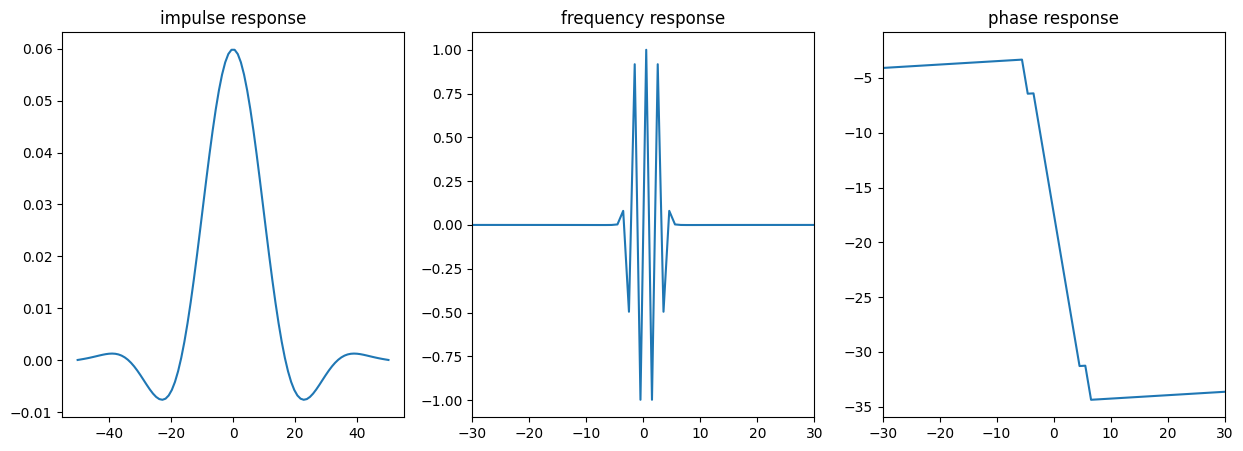

In [14]:
# Your Code Goes Here
h_lpf = firwin(100, 30, fs=fs)
n = np.linspace(-50,50,100)
H_lpf = scipy.fft.fftshift(fft(h_lpf))

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(15,5))

ax1.plot(n,h_lpf)
ax1.set_title('impulse response')

ax2.plot(n,H_lpf)
ax2.set_title('frequency response')
ax2.set_xlim(-30,30)

ax3.plot(n,np.unwrap(np.angle(H_lpf)))
ax3.set_title('phase response')
ax3.set_xlim(-30,30)

<div class="alert alert-success">
<span style="color:black">
    
* Text answers go here



<div class="alert alert-info">
    
- Filter the EEG recording with the filter (use `lfilter`) and investigate the effect before and after in the time and frequency domain. What happened to the 60-Hz line noise? Is there still evidence of brain activity in the signal?

- What is the origin of the peak of the filtered signal at 0.25 s in the time-domain?

Text(0.5, 1.0, 'EEG amplitude spectrum')

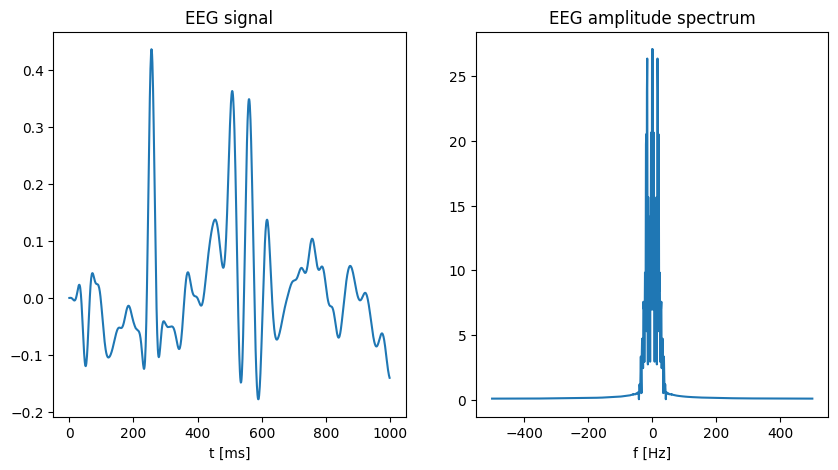

In [19]:
# Your Code Goes Here

x = eeg[0]
x = lfilter(h_lpf, 1, x)

fig, ax = plt.subplots(ncols=2, figsize=(10,5))

X = scipy.fft.fftshift(fft(x))

ax[0].plot(x)
ax[0].set_xlabel('t [ms]')
ax[0].set_title('EEG signal')

ax[1].plot(f, abs(X))
ax[1].set_xlabel('f [Hz]')
ax[1].set_title('EEG amplitude spectrum')

<div class="alert alert-success">
<span style="color:black">
    
* Text answers go here
    
The $60\text{Hz}$ line noise has been filtered out.

------
You probably realise that the FIR filter we designed previously introduces a _uniform_ (constant) time shift in the resulting signal. This means that all frequencies are shifted by the same amount in time. Such FIR filters are known as _linear phase_ filters. The magnitude of the time shift can be seen in both the impulse response after application to the EEG signal. However, in many applications, we’re interested in the precise timing of neural events. For example, if we’d like to understand the EEG response following a stimulus presentation, we must carefully preserve the timing of EEG features (e.g., cross-frequency coupling, auditory brainstem response). In these contexts and others, shifts in the EEG signal must be either well understood and accounted for, or avoided.

<div class="alert alert-info">
    
**Task: Zero-phase filtering**

- To eliminate phase shifts introduced by the filter, you can apply the same filter twice to the data (zero-phase filtering). First, apply the FIR filter to the original input signal. This filtering operation introduces a shift (of size n/2 indices, or 0.05 s for our data) in the resulting EEG. Second, *reverse* the filtered signal `flip()` and then apply the same FIR filter again to the reversed sequence. The outcome of this second filtering operation is our desired signal: the filtered data without the phase shift. Compare the time-domain and phase response of the filtered signal between the FIR and zero-phase filtering procedure.

- Instead of using the above procedure, you can also use the `filtfilt()` directly to perform 0-phase filtering with the desired lowpass FIR filter. Hopefully you obtain the same outcome when using this function.

In [ ]:
# Your Code Goes Here

### Evaluation with an IIR filter

Now let us consider an IIR low-pass filter with the same cut-off. 

<div class="alert alert-info">
    
**Task: IIR filtering**
    
- Use the `butter` function from `scipy.signal` to define the IIR low-pass filter with `28 Hz` cut-off frequency. The filter order should be `8`. Plot the amplitude and phase response of this filter. 
    
- Again, zoom into the passband. What does the phase response tell you regarding the shifting of the different frequencies?  

In [ ]:
# Your Code Goes Here

<div class="alert alert-success">
<span style="color:black">
    
* Text answers go here

<div class="alert alert-info">
    
- Filter the EEG recording with the filter (use `lfilter`) and investigate the effect before and after in the time and frequency domain. What happened to the 60-Hz line noise? Is there still evidence of brain activity in the signal?

- The amplitude characteristics of the IIR and the previously designed FIR filter are approximately the same. What is the difference you observe in the filtered signals in terms of their waveforms (compare the output of the IIR-filtered signal with the FIR filtered signal)?  **Tip** non-linear phase means that different frequency components are differently delayed through the filter. See if you can spot such patterns when looking at the time domain outputs after FIR and IIR filtering? Do the signals maintain a constant delay with respect to one another?

In [ ]:
# Your Code Goes Here

<div class="alert alert-success">
<span style="color:black">
    
* Text answers go here

<div class="alert alert-info">
    
**Task: Zero-phase filtering for IIR**

- Here too, we can apply zero-phase filtering to eliminate phase shifts introduced by the filter. Perform this using `filtfilt()` and now compare the results of the FIR output and the IIR output (both after zero-phase filtering). What do you observe? **Tip:** do the comparison in the time-domain.


In [ ]:
# Your Code Goes Here

<div class="alert alert-success">
<span style="color:black">

    
* Text answers go here
    


## Analysis of the Filtered EEG Data
The primary scientific goal of this dataset was to determine whether the provided EEG data exhibit an evoked response. The initial analysis hinted that an evoked response might occur but that it was hidden by the large electrical noise—and perhaps other noise—inherent in the EEG data. 

For this dataset the noise is typically in the high-frequency region. To reduce this noise, we lowpass filtered the EEG signal (zero-phase filter) in _each_ of the epochs and then compute the average time-domain signal and the power spectrum. Does this resultant signal tell us anything about the presence of an evoked response?

<div class="alert alert-info">
    
**Task: Evoked Response?**

- Complete the code where necessary to perform the above filtering and averaging.
- Analyse your EEG data after filtering, is there an evoked response, and what are its characteristics?
- Perhaps comparing this signal to the unfiltered one may show you what the benefit of the filtering is.

In [ ]:
# Your Code Goes Here
# You will now use all the epochs of the EEG data.

# First we compute the number of epochs in the data.
nTrials = eeg.shape[0]

# Filter each epoch of the EEG data with the previously designed FIR filter. 
# Do this in the zero-phase manner. You may use the appropriate scipy function for this.
# Store the result in variable eegFilt


# Compute the mean and standard deviation of the filtered signal across TRIALS (epochs). Not across time!
mu = eegFilt.mean(axis=)
sigma = eegFilt.std(axis=)
# Compute the standard deviation of the sample-mean estimate
sigma_mean = sigma/np.sqrt(<??>) # Look up the formula for this from previous lectures.

# Now plot this
fig,ax = plt.subplots()
ax.plot(t,mu)                   # Plot the ERP of the filtered data
ax.plot(t, mu + 2 * sigma_mean, 'r:'); # ... and the confidence intervals,
ax.plot(t, mu - 2 * sigma_mean, 'r:');
ax.set_xlabel('Time [s]')            # ... and label the axes.
ax.set_ylabel('Voltage [ mV]')
ax.set_title('Evoked response')
plt.show()

# And now compute the spectrum of the ERP over all trials and then average the periodograms. 

nfft = t.size                                          # Size of the DFT is equal to length of an epoch.
frqAxis = fft.fftfreq(nfft,1/fs)[:nfft//2]             # Define the positive frequency axis.

Sxx = np.zeros((nfft//2,nTrials),dtype='complex128')   # Periodogram matrix.
window = signal.hann(nfft)

for trialIdx in range(nTrials):
    X = fft.fft(eegFilt[trialIdx,:]*window)[0:nfft//2]    # Compute the positive DFT spectrum.
    Sxx[:,trialIdx] = <??>             # Compute the periodogram from X.
    
# Compute the average of the periodogram over the epochs to get the power spectrum estimate.

SxxAvg = <??> 
fig,ax = plt.subplots()
ax.plot(frqAxis, 10 * np.log10(SxxAvg))     # Plot the result in decibels vs frequency,
ax.set_xlim([0, 100])                        # ... in limited frequency range,
ax.set_ylim([-10, 40])                         # ... and a limited power range,
ax.set_xlabel('Frequency [Hz]')               # ... with axes labeled.
ax.set_ylabel('Power [dB]')
title('Trial averaged spectrum')
plt.show()

# You can plot the time-averaged signal and power spectrum of the unfiltered signal. 
# How informative is this?

<div class="alert alert-success">
<span style="color:black">

* Discuss what you see here.
    
